Changes Made from Previous Attempt:

In [36]:
# Changes made:

# Model definition completely updated, shifted to 3.2
# Dataset is updated, shifted to 3.2 (used research_based.ipynb to augment data and produce 2x)

# Pre-Processing:

Importing Libraries:

In [37]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import clear_output, display
import ipywidgets as widgets
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
from tqdm import tqdm
from PIL import Image
from torch.optim.lr_scheduler import OneCycleLR
from collections import Counter
from torch.utils.data.sampler import Sampler




Importing Files:

In [38]:
from PreGeneratedTripletDataset import PreGeneratedTripletDataset
from EHTM_Sampler import EHTMSampler

Setting Paths, Seed & Device:

In [39]:
TRAIN_PATH = '/Users/Shared/FYP/Capstone Project II - 3.2/Dataset/train'
VAL_PATH = '/Users/Shared/FYP/Capstone Project II - 3.2/Dataset/val'
print('Training Path:', TRAIN_PATH)
print('Validation Path:', VAL_PATH)

MARGIN = 0.8
NUM_EPOCHS = 80

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
print('Seed set to:', SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Training Path: /Users/Shared/FYP/Capstone Project II - 3.2/Dataset/train
Validation Path: /Users/Shared/FYP/Capstone Project II - 3.2/Dataset/val
Seed set to: 42
Using MPS (Apple Silicon GPU)


Transformation:

In [40]:
transform = transforms.Compose([
    # The following transformation applies random changes to the brightness, contrast, saturation, and hue of the images to augment the dataset.
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

**Preparing and Genertaing Triplets & Batch Size:**

In [41]:
# import from PreGeneratedTripletDataset.py

In [42]:
train_dataset = PreGeneratedTripletDataset(data_path=TRAIN_PATH, transform=transform)
val_dataset = PreGeneratedTripletDataset(data_path=VAL_PATH, transform=val_transform)

print(f"Number of training triplets: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

# Set batch size
batch_size = 48

# Create custom sampler for better batch composition
ehtm_sampler = EHTMSampler(
    dataset=train_dataset, 
    batch_size=batch_size, 
    num_instances=4  # 4 triplets per person in each batch
)

# Create dataloaders
# Use custom sampler instead of shuffle
train_loader = DataLoader(
    train_dataset, 
    batch_sampler=ehtm_sampler,  # Use batch_sampler instead of sampler
    num_workers=2
)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

Number of training triplets: 19769
Number of validation images: 4537
EHTMSampler initialized:
  - Total persons: 747
  - Valid persons (>=4 triplets): 737
  - Batch composition: 12 persons × 4 instances


In [43]:
print(f"Total triplets generated in train_dataset: {len(train_dataset.triplets)}")
unique_ids = len(set(train_dataset.person_images.keys()))  # Count unique identities based on person_images
print(f"Total unique identities in train dataset: {unique_ids}")

id_counts = Counter([os.path.basename(os.path.dirname(anchor)) for anchor, _, _ in train_dataset.triplets])
print(f"Triplet count per ID (sample): {dict(list(id_counts.items())[:10])}")

Total triplets generated in train_dataset: 19769
Total unique identities in train dataset: 750
Triplet count per ID (sample): {'0987': 24, '0389': 5, '0973': 34, '1432': 16, '0184': 52, '1056': 23, '0726': 31, '0148': 66, '0513': 18, '0177': 28}


In [44]:
# Sanity check: Test a few triplets to make sure they're formed correctly
print("\n=== TRIPLET SANITY CHECK ===")
for i in range(min(3, len(train_dataset))):
    anchor, positive, negative, anchor_label, neg_label = train_dataset[i]
    anchor_path, pos_path, neg_path = train_dataset.triplets[i]
    
    anchor_id = os.path.basename(os.path.dirname(anchor_path))
    pos_id = os.path.basename(os.path.dirname(pos_path))
    neg_id = os.path.basename(os.path.dirname(neg_path))
    
    print(f"Triplet {i}:")
    print(f"  Anchor ID: {anchor_id} (tensor: {anchor_label.item()})")
    print(f"  Pos ID: {pos_id} (should match anchor)")
    print(f"  Neg ID: {neg_id} (tensor: {neg_label.item()}, should differ)")
    print(f"  Valid triplet: {anchor_id == pos_id and anchor_id != neg_id}")
    print()


=== TRIPLET SANITY CHECK ===
Triplet 0:
  Anchor ID: 0987 (tensor: 987)
  Pos ID: 0987 (should match anchor)
  Neg ID: 1140 (tensor: 1140, should differ)
  Valid triplet: True

Triplet 1:
  Anchor ID: 0987 (tensor: 987)
  Pos ID: 0987 (should match anchor)
  Neg ID: 1335 (tensor: 1335, should differ)
  Valid triplet: True

Triplet 2:
  Anchor ID: 0987 (tensor: 987)
  Pos ID: 0987 (should match anchor)
  Neg ID: 0862 (tensor: 862, should differ)
  Valid triplet: True



t-SNE Raw Data Visualization:

In [45]:
# def plot_raw_data_points(dataset, title_suffix="", group_by="person_id"):
#     """
#     Visualize raw person images using t-SNE dimensionality reduction
    
#     Parameters:
#     - dataset: PreGeneratedTripletDataset instance
#     - title_suffix: Additional text for the plot title
#     - group_by: Field to group by (only 'person_id' supported for now)
#     """
#     # Get a set of unique person images from the triplets
#     all_images = set()
#     person_ids = {}
    
#     # Use all available samples
#     sampled_indices = range(len(dataset))
    
#     # Extract unique images and their IDs
#     for idx in sampled_indices:
#         anchor, positive, negative, anchor_label, negative_label = dataset[idx]
        
#         # Get paths from dataset to use as unique identifiers
#         anchor_path = dataset.triplets[idx][0]
#         positive_path = dataset.triplets[idx][1]
#         negative_path = dataset.triplets[idx][2]
        
#         # Add anchor and record its person ID
#         if anchor_path not in all_images:
#             all_images.add(anchor_path)
#             person_ids[anchor_path] = anchor_label
            
#         # Add positive and record its person ID (same as anchor)
#         if positive_path not in all_images:
#             all_images.add(positive_path)
#             person_ids[positive_path] = anchor_label
            
#         # Add negative and record its person ID
#         if negative_path not in all_images:
#             all_images.add(negative_path)
#             person_ids[negative_path] = negative_label
    
#     # Convert to lists
#     image_paths = list(all_images)
#     labels = [person_ids[path] for path in image_paths]
    
#     # Extract raw image data
#     raw_data = []
#     for path in image_paths:
#         img = Image.open(path).convert('RGB')
#         if dataset.transform:
#             img = dataset.transform(img)
#         # Convert to numpy and flatten
#         img_np = np.array(img)  # Convert PIL Image to numpy array
#         img_flat = img_np.reshape(-1)  # Flatten to 1D
#         raw_data.append(img_flat)
    
#     raw_data = np.vstack(raw_data)
#     labels = np.array(labels)
    
#     # Use t-SNE for dimensionality reduction
#     print("Computing t-SNE embedding...")
#     tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(raw_data)-1))
#     reduced_data = tsne.fit_transform(raw_data)
    
#     # Plot the results
#     plt.figure(figsize=(16, 12))
#     unique_persons = np.unique(labels)
    
#     # Create colormap with enough colors
#     # Use HSV color space for better color separation
#     n_colors = len(unique_persons)
#     colors = plt.cm.hsv(np.linspace(0, 1, n_colors))

#     # Shuffle the colors to avoid similar adjacent colors
#     np.random.seed(42)  # For reproducibility
#     np.random.shuffle(colors)
    
#     for i, person_id in enumerate(unique_persons):
#         indices = np.where(labels == person_id)
#         plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], 
#                     s=50, color=colors[i])
    
#     plt.title(f"Person Re-ID Raw Image Visualization {title_suffix}", fontsize=20)
    
#     plt.xlabel("t-SNE Component 1", fontsize=14)
#     plt.ylabel("t-SNE Component 2", fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()

# plot_raw_data_points(dataset=train_dataset, title_suffix="(Raw Image Features)")

Number of Images per Unique Class:

In [46]:
# def visualize_class_distribution(dataset, title_suffix):
#     person_ids = dataset.person_ids
#     person_images = dataset.person_images

#     num_images_per_class = [len(person_images[pid]) for pid in person_ids]

#     # Determine the highest and lowest number of images per class
#     max_images = max(num_images_per_class)
#     min_images = min(num_images_per_class)
#     print(f"Highest number of images in a class: {max_images}")
#     print(f"Lowest number of images in a class: {min_images}")

#     fig, ax = plt.subplots(figsize=(16, 8))
#     ax.bar(person_ids, num_images_per_class, color='skyblue')
#     ax.set_xlabel('Person ID', fontsize=14)
#     ax.set_ylabel('Number of Images', fontsize=14)
#     ax.set_title(f'Number of Images per Class {title_suffix}', fontsize=20)
#     ax.set_xticks(person_ids)
#     ax.set_xticklabels(person_ids, rotation=90)
#     ax.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()

#     # Make the plot horizontally scrollable
#     ax.set_xlim(-0.5, len(person_ids) - 0.5)
#     ax.set_xmargin(0.01)
#     fig.canvas.draw()
#     scrollable_width = max(16, len(person_ids) / 5)
#     fig.set_size_inches(scrollable_width, 8)

#     plt.show()

# # Visualize training data class distribution
# visualize_class_distribution(train_dataset, "(Training Data)")

# # Visualize validation data class distribution
# visualize_class_distribution(val_dataset, "(Validation Data)")


Visualize Triplets:

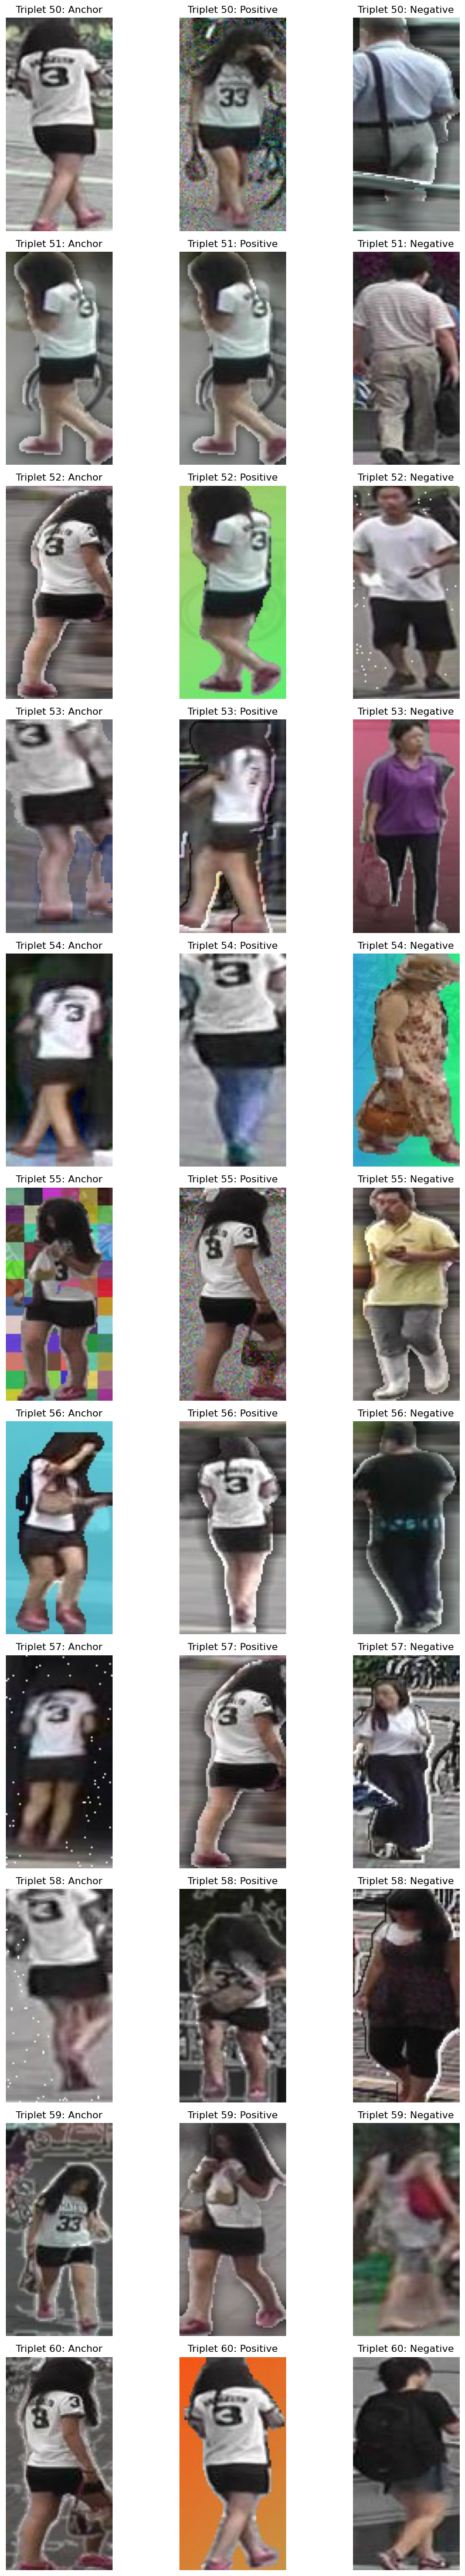

In [47]:
def show_multiple_triplets(dataset, start_idx, end_idx):
    num_triplets = end_idx - start_idx + 1
    fig, axes = plt.subplots(num_triplets, 3, figsize=(10, 4 * num_triplets))

    for i, idx in enumerate(range(start_idx, end_idx + 1)):
        anchor_path, positive_path, negative_path = dataset.triplets[idx]

        anchor = Image.open(anchor_path)
        positive = Image.open(positive_path)
        negative = Image.open(negative_path)

        axes[i, 0].imshow(anchor)
        axes[i, 0].set_title(f"Triplet {idx}: Anchor")
        axes[i, 1].imshow(positive)
        axes[i, 1].set_title(f"Triplet {idx}: Positive")
        axes[i, 2].imshow(negative)
        axes[i, 2].set_title(f"Triplet {idx}: Negative")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

show_multiple_triplets(train_dataset, 50, 60)

In [48]:
# Cell 5: Model definition
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, max(channels // reduction_ratio, 8), kernel_size=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(max(channels // reduction_ratio, 8), channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False),  # Reduced kernel size for smaller inputs
            nn.Sigmoid()
        )
    
    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        sa_input = torch.cat([
            torch.mean(x, dim=1, keepdim=True),
            torch.max(x, dim=1, keepdim=True)[0]
        ], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

class Person_ReID(nn.Module):
    def __init__(self):
        super(Person_ReID, self).__init__()
        
        # Static filters with no downsampling
        self.static_conv = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
        # First layer with reduced stride to preserve spatial info
        self.trainable_conv = nn.Conv2d(3, 13, kernel_size=3, stride=1, padding=1, bias=False)
        self._initialize_static_filters()
        
        self.bn1 = nn.BatchNorm2d(16)
        
        # Reduced number of downsamplings for 128x64 input
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 128x64 -> 64x32
            nn.BatchNorm2d(32),
            nn.ELU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x32 -> 32x16
            nn.BatchNorm2d(64),
            nn.ELU()
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x16 -> 16x8
            nn.BatchNorm2d(128),
            nn.ELU()
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 16x8 -> 16x8
            nn.BatchNorm2d(256),
            nn.ReLU6()
        )
        
        # CBAM attention modules
        self.cbam4 = CBAM(128, reduction_ratio=8)
        self.cbam5 = CBAM(256, reduction_ratio=8)
        
        # Skip connections with appropriate strides
        self.skip_16_to_32 = nn.Conv2d(16, 32, kernel_size=1, stride=2, bias=False)
        self.skip_32_to_64 = nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False)
        self.skip_64_to_128 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        self.skip_128_to_256 = nn.Conv2d(128, 256, kernel_size=1, bias=False)
        
        # Dropout for regularization
        self.dropout5 = nn.Dropout(0.3)
        
        # Part-based features - 3 parts instead of 2 for a 16x8 feature map (head, torso, legs)
        self.part_pools = nn.ModuleList([
            nn.AdaptiveAvgPool2d((1, 1)),  # Global
            nn.AdaptiveMaxPool2d((6, 1))   # 3 vertical parts for person Re-ID
        ])
        
        # Global pool
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # Enhanced global feature projection
        self.fc_global = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            #nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128)
        )
        
        # Part-based feature projections (6 parts)
        self.fc_parts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 128),
                nn.LayerNorm(128)
            ) for _ in range(6)  # For 6 body parts
        ])

        # Initialize weights
        self._initialize_weights()
    
    def _initialize_static_filters(self):
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        laplacian = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32)
        smooth = torch.full((3, 3), 1/9.0, dtype=torch.float32)
        
        with torch.no_grad():
            self.static_conv.weight[0] = sobel_x.repeat(3, 1, 1)
            self.static_conv.weight[1] = laplacian.repeat(3, 1, 1)
            self.static_conv.weight[2] = smooth.repeat(3, 1, 1)
        
        self.static_conv.weight.requires_grad = False
    
    def _initialize_weights(self):
        """Initialize weights using Xavier/Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature extraction
        x_static = self.static_conv(x)
        x_trainable = self.trainable_conv(x)
        x1 = torch.cat([x_static, x_trainable], dim=1)
        x1 = F.leaky_relu(self.bn1(x1), 0.1)  # 128x64 spatial size
        
        # Layer 2 with skip connection
        x2 = self.conv2(x1)  # 64x32 spatial size
        x2_skip = self.skip_16_to_32(x1)
        x2 = x2 + x2_skip
        
        # Layer 3 with skip connection
        x3 = self.conv3(x2)  # 32x16 spatial size
        x3_skip = self.skip_32_to_64(x2)
        x3 = x3 + x3_skip
        
        # Layer 4 with skip connection and attention
        x4 = self.conv4(x3)  # 16x8 spatial size
        x4_skip = self.skip_64_to_128(x3)
        x4 = x4 + x4_skip
        x4 = self.cbam4(x4)
        
        # Layer 5 with skip connection and attention
        x5 = self.conv5(x4)  # 16x8 spatial size
        x5_skip = self.skip_128_to_256(x4)
        x5 = x5 + x5_skip
        x5 = self.cbam5(x5)
        x5 = self.dropout5(x5)
        
        # Global feature extraction
        global_feat = self.global_pool(x5)
        global_feat = self.flatten(global_feat)
        global_embedding = self.fc_global(global_feat)
        global_embedding = F.normalize(global_embedding, p=2, dim=1)
        
        # Part-based feature extraction (during training only)
        if self.training:
            # Get 3 vertical parts (head, torso, legs)
            parts = self.part_pools[1](x5)  # Shape: [B, C, 3, 1]
            part_features = []
            
            for i in range(6):
                part = parts[:, :, i, :]
                part = part.view(part.size(0), -1)
                part_emb = self.fc_parts[i](part)
                part_emb = F.normalize(part_emb, p=2, dim=1)
                part_features.append(part_emb)
            
            return global_embedding, part_features
        
        return global_embedding

Model's Summary:

In [49]:
# Print model's summary
from torchsummary import summary
model = Person_ReID()

model.eval()
#model.to(device)

dummy_input = torch.randn(1, 3, 128, 64)
summary(model, (3, 128, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 128, 64]              81
            Conv2d-2          [-1, 13, 128, 64]             351
       BatchNorm2d-3          [-1, 16, 128, 64]              32
            Conv2d-4           [-1, 32, 64, 32]           4,640
       BatchNorm2d-5           [-1, 32, 64, 32]              64
               ELU-6           [-1, 32, 64, 32]               0
            Conv2d-7           [-1, 32, 64, 32]             512
            Conv2d-8           [-1, 64, 32, 16]          18,496
       BatchNorm2d-9           [-1, 64, 32, 16]             128
              ELU-10           [-1, 64, 32, 16]               0
           Conv2d-11           [-1, 64, 32, 16]           2,048
           Conv2d-12           [-1, 128, 16, 8]          73,856
      BatchNorm2d-13           [-1, 128, 16, 8]             256
              ELU-14           [-1, 128

In [50]:
from thop import profile


model = Person_ReID()
model.eval()

input_shape = (1, 3, 64, 128)
dummy_input = torch.randn(input_shape)
flops, params = profile(model, inputs=(dummy_input,))

print(f"FLOPs per image: {flops:,}")
print(f"GFLOPs per image: {flops / 1e9:.2f} GFLOPs")
print(f"Total FLOPs for 100 images: {flops * 100:,}")
print(f"Total GFLOPs for 100 images: {flops * 100 / 1e9:.2f} GFLOPs")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.AdaptiveMaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
FLOPs per image: 78,260,864.0
GFLOPs per image: 0.08 GFLOPs
Total FLOPs for 1

Validate Inputs to Loss Function:

In [51]:
class EHTMLoss(nn.Module):
    def __init__(self, margin=0.8, lambda_intra=0.1, lambda_inter=0.1):
        super(EHTMLoss, self).__init__()
        self.margin = margin
        self.lambda_intra = lambda_intra  # Weight for intraclass term
        self.lambda_inter = lambda_inter  # Weight for interclass term
        
    def forward(self, anchor, positive, negative, anchor_labels, negative_labels):
        # Ensure all tensors are on the same device as anchor
        device = anchor.device
        #print(f"Anchor device: {anchor.device}")
        positive = positive.to(device)
        negative = negative.to(device)
        anchor_labels = anchor_labels.to(device)
        negative_labels = negative_labels.to(device)
        
        # Standard triplet loss component
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
        triplet_loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        
        # Exhaustive hard triplet mining within batch
        batch_size = anchor.size(0)
        
        # Compute all pairwise distances - MPS optimized version
        all_embeddings = torch.cat([anchor, positive, negative], dim=0)
        all_labels = torch.cat([anchor_labels, anchor_labels, negative_labels], dim=0)
        
        # MPS-optimized pairwise distance computation using broadcasting
        # Instead of torch.cdist, use manual computation that's MPS compatible
        def compute_pairwise_distances(x, y):
            # x: (n, d), y: (m, d) -> output: (n, m)
            x_norm = (x**2).sum(dim=1, keepdim=True)  # (n, 1)
            y_norm = (y**2).sum(dim=1, keepdim=True)  # (m, 1)
            xy = torch.mm(x, y.t())  # (n, m)
            return torch.sqrt(torch.clamp(x_norm - 2*xy + y_norm.t(), min=1e-8))
        
        pairwise_dist = compute_pairwise_distances(all_embeddings, all_embeddings)
        
        # Mine different types of hard triplets
        hard_triplet_losses = []
        
        # 1. Hard positive mining (for each anchor, find hardest positive)
        for i in range(batch_size):
            anchor_label = anchor_labels[i]
            
            # Find all positives for this anchor
            positive_mask = (all_labels == anchor_label) & (torch.arange(len(all_labels), device=device) != i)
            if positive_mask.sum() > 0:
                positive_distances = pairwise_dist[i][positive_mask]
                hardest_pos_dist = positive_distances.max()
                
                # Find all negatives for this anchor
                negative_mask = (all_labels != anchor_label)
                if negative_mask.sum() > 0:
                    negative_distances = pairwise_dist[i][negative_mask]
                    hardest_neg_dist = negative_distances.min()
                    
                    # Hard triplet loss
                    hard_loss = torch.clamp(hardest_pos_dist - hardest_neg_dist + self.margin, min=0.0)
                    hard_triplet_losses.append(hard_loss)
        
        # 2. Semi-hard triplet mining
        semi_hard_losses = []
        for i in range(batch_size):
            anchor_label = anchor_labels[i]
            
            positive_mask = (all_labels == anchor_label) & (torch.arange(len(all_labels), device=device) != i)
            negative_mask = (all_labels != anchor_label)
            
            if positive_mask.sum() > 0 and negative_mask.sum() > 0:
                pos_distances = pairwise_dist[i][positive_mask]
                neg_distances = pairwise_dist[i][negative_mask]
                
                # Semi-hard condition: pos_dist < neg_dist < pos_dist + margin
                for pos_dist in pos_distances:
                    valid_negs = neg_distances[(neg_distances > pos_dist) & 
                                             (neg_distances < pos_dist + self.margin)]
                    if len(valid_negs) > 0:
                        semi_hard_neg = valid_negs.min()
                        semi_hard_loss = torch.clamp(pos_dist - semi_hard_neg + self.margin, min=0.0)
                        semi_hard_losses.append(semi_hard_loss)
        
        # 3. Intraclass distance minimization term - MPS optimized
        intraclass_loss = 0
        unique_labels = torch.unique(anchor_labels)
        for label in unique_labels:
            label_mask = (all_labels == label)
            if label_mask.sum() > 1:
                label_embeddings = all_embeddings[label_mask]
                # Use our custom distance function instead of torch.cdist
                label_distances = compute_pairwise_distances(label_embeddings, label_embeddings)
                # Average pairwise distance within class
                intraclass_loss += label_distances.sum() / (label_mask.sum() * (label_mask.sum() - 1))
        
        # 4. Interclass distance maximization term (implicit through margin) - MPS optimized
        interclass_loss = 0
        # Option 2: If you want interclass term, use margin-based approach:
        for i, label1 in enumerate(unique_labels):
            for j, label2 in enumerate(unique_labels):
                if i < j:  # Avoid double counting
                    mask1 = (all_labels == label1)
                    mask2 = (all_labels == label2)
                    if mask1.sum() > 0 and mask2.sum() > 0:
                        emb1 = all_embeddings[mask1]
                        emb2 = all_embeddings[mask2]
                        inter_dist = compute_pairwise_distances(emb1, emb2)
                        # Use margin-based loss: penalize if distance < margin
                        interclass_loss += torch.clamp(self.margin - inter_dist.mean(), min=0.0)
        
        
        # Combine all loss components
        total_triplet_loss = triplet_loss.mean()
        if hard_triplet_losses:
            total_triplet_loss += torch.stack(hard_triplet_losses).mean()
        if semi_hard_losses:
            total_triplet_loss += torch.stack(semi_hard_losses).mean()
        
        total_loss = total_triplet_loss + \
                    self.lambda_intra * intraclass_loss + \
                    self.lambda_inter * interclass_loss
        
        return total_loss


How DataLoader is shuffling batches:

In [52]:
# #See how dataloader is loading the triplets
# for batch_idx, (anchors, positives, negatives, anchor_labels, negative_labels) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}")
#     print(f"Anchor Labels: {anchor_labels}")
#     print(f"Negative Labels: {negative_labels}")
#     print(f"Total number of triplets in the batch: {anchors.shape[0]}")
#     # Optionally, you can visualize the images using matplotlib or any other library
#     # For example, to visualize the first triplet in the batch:
#     # plt.imshow(anchors[0].permute(1, 2, 0))  # Assuming the images are in CHW format
#     # plt.title(f"Anchor - Label: {anchor_labels[0]}")
#     # plt.show()
#     # plt.imshow(positives[0].permute(1, 2, 0))
#     # plt.title("Positive")
#     # plt.show()
#     # plt.imshow(negatives[0].permute(1, 2, 0))
#     # plt.title(f"Negative - Label: {negative_labels[0]}")
#     # plt.show()
    
#     if batch_idx == 3:  # Change this number to inspect more batches
#         break

Visualizing Batch Ditribution:

In [53]:
# # Function to analyze batch class distribution
# def analyze_batch_distribution(dataloader, num_batches=50):
#     """
#     Analyze the distribution of classes across batches
    
#     Args:
#         dataloader: PyTorch DataLoader for your triplet dataset
#         num_batches: Number of batches to analyze (50 by default)
    
#     Returns:
#         batch_data: List of dictionaries with batch class statistics
#         all_classes: Set of all class IDs observed
#     """
#     batch_data = []
#     all_classes = set()
    
#     print(f"Analyzing {num_batches} batches...")
    
#     for batch_idx, batch in tqdm(enumerate(dataloader), total=num_batches):
#         if batch_idx >= num_batches:
#             break
            
#         # Unpack batch: anchor, positive, negative, anchor_label, negative_label
#         _, _, _, anchor_labels, negative_labels = batch
        
#         # Combine anchor and negative labels to get all person IDs in this batch
#         all_labels = list(anchor_labels) + list(negative_labels)
        
#         # Count occurrences of each class
#         class_counts = Counter(all_labels)
#         unique_classes = len(class_counts)
#         most_common_class, most_common_count = class_counts.most_common(1)[0]
        
#         # Update the set of all observed classes
#         all_classes.update(class_counts.keys())
        
#         # Store batch statistics
#         batch_data.append({
#             'batch_idx': batch_idx,
#             'unique_classes': unique_classes,
#             'most_common_class': most_common_class,
#             'most_common_count': most_common_count,
#             'class_counts': dict(class_counts),
#             'class_diversity': unique_classes / len(all_labels)
#         })
    
#     return batch_data, all_classes

# # Run the analysis
# batch_data, all_classes = analyze_batch_distribution(train_loader)

# # Convert results to DataFrame for easier analysis
# df = pd.DataFrame(batch_data)

# # Create visualizations
# plt.figure(figsize=(18, 14))

# # 1. Number of unique classes per batch
# plt.subplot(2, 2, 1)
# plt.bar(df['batch_idx'], df['unique_classes'], color='skyblue')
# plt.axhline(df['unique_classes'].mean(), color='red', linestyle='--', label=f'Mean: {df["unique_classes"].mean():.1f}')
# plt.xlabel('Batch Index')
# plt.ylabel('Number of Unique Classes')
# plt.title('Number of Unique Classes per Batch')
# plt.legend()

# # 2. Class diversity ratio per batch
# plt.subplot(2, 2, 2)
# plt.bar(df['batch_idx'], df['class_diversity'], color='lightgreen')
# plt.axhline(df['class_diversity'].mean(), color='red', linestyle='--', label=f'Mean: {df["class_diversity"].mean():.2f}')
# plt.xlabel('Batch Index')
# plt.ylabel('Class Diversity Ratio')
# plt.title('Class Diversity Ratio per Batch\n(Unique Classes / Total Samples)')
# plt.legend()

# # 3. Most common class count per batch
# plt.subplot(2, 2, 3)
# plt.bar(df['batch_idx'], df['most_common_count'], color='salmon')
# plt.axhline(df['most_common_count'].mean(), color='blue', linestyle='--', label=f'Mean: {df["most_common_count"].mean():.1f}')
# plt.xlabel('Batch Index')
# plt.ylabel('Count of Most Common Class')
# plt.title('Most Common Class Occurrence per Batch')
# plt.legend()

# # 4. Heat map of class distribution across batches
# plt.subplot(2, 2, 4)

# # Create a matrix of class occurrences across batches
# all_classes_list = sorted(list(all_classes))
# class_matrix = np.zeros((len(all_classes_list), len(batch_data)))

# for i, batch in enumerate(batch_data):
#     for class_id, count in batch['class_counts'].items():
#         class_idx = all_classes_list.index(class_id)
#         class_matrix[class_idx, i] = count

# # Sample a subset of classes for visualization if there are too many
# max_classes_to_show = 30
# if len(all_classes_list) > max_classes_to_show:
#     # Select classes with highest total counts
#     class_totals = class_matrix.sum(axis=1)
#     top_class_indices = np.argsort(class_totals)[-max_classes_to_show:]
#     class_matrix = class_matrix[top_class_indices]
#     all_classes_list = [all_classes_list[i] for i in top_class_indices]

# # Plot heatmap
# sns.heatmap(class_matrix, cmap='viridis', 
#             xticklabels=range(len(batch_data)), 
#             yticklabels=all_classes_list,
#             cbar_kws={'label': 'Count in Batch'})
# plt.xlabel('Batch Index')
# plt.ylabel('Class ID')
# plt.title(f'Distribution of Top {len(all_classes_list)} Classes Across Batches')

# plt.tight_layout()
# plt.show()

# # Additional analysis: Overall class distribution
# plt.figure(figsize=(12, 6))

# # Flatten all class counts across batches
# all_counts = {}
# for batch in batch_data:
#     for class_id, count in batch['class_counts'].items():
#         all_counts[class_id] = all_counts.get(class_id, 0) + count

# # Convert to DataFrame for easier plotting
# class_df = pd.DataFrame({
#     'class_id': list(all_counts.keys()),
#     'total_samples': list(all_counts.values())
# })
# class_df = class_df.sort_values('total_samples', ascending=False)

# # Plot top 50 classes
# top_n = 50
# plt.bar(range(min(top_n, len(class_df))), class_df['total_samples'].head(top_n), color='lightblue')
# plt.xlabel('Class Rank')
# plt.ylabel('Total Samples')
# plt.title(f'Total Samples per Class (Top {min(top_n, len(class_df))} Classes)')
# plt.xticks(range(min(top_n, len(class_df))), class_df['class_id'].head(top_n), rotation=90)
# plt.tight_layout()
# plt.show()

# # Calculate and print summary statistics
# print("\n===== Batch Distribution Statistics =====")
# print(f"Average unique classes per batch: {df['unique_classes'].mean():.2f} ± {df['unique_classes'].std():.2f}")
# print(f"Average class diversity ratio: {df['class_diversity'].mean():.2f} ± {df['class_diversity'].std():.2f}")
# print(f"Average count of most common class: {df['most_common_count'].mean():.2f} ± {df['most_common_count'].std():.2f}")
# print(f"Total unique classes across all batches: {len(all_classes)}")

# # Gini coefficient to measure inequality in class distribution
# def gini_coefficient(x):
#     """Calculate the Gini coefficient of a numpy array."""
#     # Mean absolute difference
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     # Relative mean absolute difference
#     rmad = mad / np.mean(x)
#     # Gini coefficient
#     return 0.5 * rmad

# class_distribution = np.array(list(all_counts.values()))
# gini = gini_coefficient(class_distribution)
# print(f"Gini coefficient of class distribution: {gini:.4f} (0=perfect equality, 1=perfect inequality)")

# # Identify classes that might be underrepresented
# underrepresented = class_df[class_df['total_samples'] < class_df['total_samples'].mean() * 0.5]
# print(f"\nNumber of potentially underrepresented classes: {len(underrepresented)} ({len(underrepresented)/len(class_df):.1%} of total)")

Netron File:

In [54]:
# import torch.onnx

# # Define the input size for the model
# dummy_input = torch.randn(1, 3, 128, 64).to(device = 'cpu')  # Adjust the size according to your model's input

# # Export the model to ONNX format
# onnx_file_path = "reid_model_3.2.onnx"
# torch.onnx.export(model, dummy_input, onnx_file_path, 
#                   export_params=True, 
#                   opset_version=11,
#                   do_constant_folding=True, 
#                   input_names=['input'], 
#                   output_names=['output'], 
#                   dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

# print(f"Model exported to ONNX format at: {onnx_file_path}")


In [55]:
model = Person_ReID().to(device)
criterion = EHTMLoss(margin=MARGIN, lambda_intra=0.1, lambda_inter=0.1)

# Initialize the optimizer with a higher base learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)


# OneCycleLR scheduler
scheduler = OneCycleLR(
    optimizer, 
    max_lr=0.001,  # Maximum learning rate
    epochs=NUM_EPOCHS, 
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos',  # Cosine annealing
    cycle_momentum=False  # Disable momentum cycling if not using SGD
)

print("Model, loss function, optimizer, and OneCycleLR scheduler initialized successfully.")

Model, loss function, optimizer, and OneCycleLR scheduler initialized successfully.


Plotting Training:

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_progress(metrics, figsize=(15, 5)):
    """Plots training and validation metrics dynamically."""
    # Skip if no data
    if not metrics['train_loss']:
        return
        
    if not hasattr(plot_training_progress, "fig"):
        plot_training_progress.fig, (plot_training_progress.ax1, plot_training_progress.ax2) = plt.subplots(1, 2, figsize=figsize)
        plot_training_progress.line1, = plot_training_progress.ax1.plot([], [], 'b-', label='Train Accuracy')
        plot_training_progress.line2, = plot_training_progress.ax1.plot([], [], 'r-', label='Validation Accuracy')
        plot_training_progress.line3, = plot_training_progress.ax2.plot([], [], 'b-', label='Train Loss')
        plot_training_progress.line4, = plot_training_progress.ax2.plot([], [], 'r-', label='Validation Loss')
        
        for ax in [plot_training_progress.ax1, plot_training_progress.ax2]:
            ax.set_xlabel('Epoch')
            ax.grid(True)
            ax.legend()
        
        plot_training_progress.ax1.set_ylabel('Accuracy')
        plot_training_progress.ax1.set_title('Training & Validation Accuracy')
        plot_training_progress.ax2.set_ylabel('Loss')
        plot_training_progress.ax2.set_title('Training & Validation Loss')
        plt.tight_layout()
        plt.show()

    epochs = np.arange(1, len(metrics['train_loss']) + 1)
    plot_training_progress.line1.set_data(epochs, metrics['train_accuracy'])
    plot_training_progress.line2.set_data(epochs, metrics['val_accuracy'])
    plot_training_progress.line3.set_data(epochs, metrics['train_loss'])
    plot_training_progress.line4.set_data(epochs, metrics['val_loss'])
    
    # Fix xlim for single epoch case
    num_epochs = len(metrics['train_loss'])
    if num_epochs == 1:
        plot_training_progress.ax1.set_xlim(0.5, 1.5)
        plot_training_progress.ax2.set_xlim(0.5, 1.5)
    else:
        plot_training_progress.ax1.set_xlim(1, num_epochs)
        plot_training_progress.ax2.set_xlim(1, num_epochs)
    
    plot_training_progress.ax1.set_ylim(0, 1)
    plot_training_progress.ax2.set_ylim(0, max(metrics['train_loss'] + metrics['val_loss']) * 1.1)
    
    # Force update
    plot_training_progress.ax1.relim()
    plot_training_progress.ax1.autoscale_view()
    plot_training_progress.ax2.relim()
    plot_training_progress.ax2.autoscale_view()
    
    plot_training_progress.fig.canvas.draw()
    plot_training_progress.fig.canvas.flush_events()
    
    epoch = len(metrics['train_loss'])
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"Train Loss: {metrics['train_loss'][-1]:.4f} | Train Acc: {metrics['train_accuracy'][-1]:.4f}")
    print(f"Val Loss: {metrics['val_loss'][-1]:.4f} | Val Acc: {metrics['val_accuracy'][-1]:.4f}")
    print(f"Time per Epoch: {metrics['epoch_time'][-1]:.2f}s")

Training Started at 12:54:30 | Total Epochs: 80


Epoch 1/80 [Training]:   0%|          | 1/411 [00:04<32:13,  4.71s/it, loss=3.9674, acc=0.7500]

DEBUG - First batch:
  Pos similarities: [0.10662442 0.85530084 0.5363251  0.577639   0.06819039]
  Neg similarities: [ 0.42924893  0.11058404  0.24550708  0.28652644 -0.00533837]
  Correct: 36/48 = 0.750
  Anchor labels: [139 193 882 249 269]
  Negative labels: [1011 1048 1055 1296  701]
  Triplet consistency check:
    Anchor-Positive same ID: True (should be True)
    Anchor-Negative diff ID: True (should be True)
  Anchor embedding stats: mean=-0.0000, std=0.0884, norm=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='mps:0',
       grad_fn=<SliceBackward0>)
  Pos embedding stats: mean=-0.0000, std=0.0884, norm=tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SliceBackward0>)
  Neg embedding stats: mean=-0.0000, std=0.0884, norm=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='mps:0',
       grad_fn=<SliceBackward0>)
  Loss value: 3.9674
  Embedding norms (should be ~1.0): anchor=[1.         0.99999994 1.        ], pos=[1. 1. 1.], neg=[0.99999994 0.99999994 1.  

Epoch 1/80 [Validation]: 100%|██████████| 95/95 [02:38<00:00,  1.67s/it, loss=2.3543, acc=0.8512]


Epoch 1 Learning Rate: 0.000044
Best model saved!


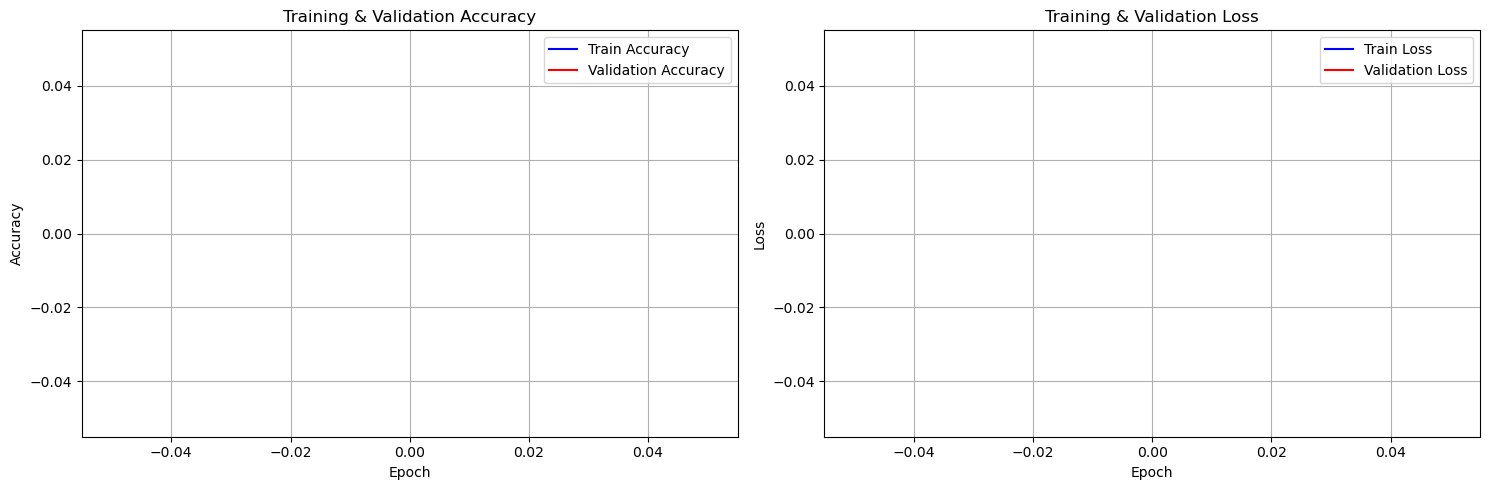

Epoch 1/80
Train Loss: 3.3419 | Train Acc: 0.8019
Val Loss: 2.7393 | Val Acc: 0.8512
Time per Epoch: 939.30s


Epoch 2/80 [Validation]: 100%|██████████| 95/95 [02:38<00:00,  1.67s/it, loss=2.2031, acc=0.8907]


Epoch 2 Learning Rate: 0.000056
Best model saved!
Epoch 2/80
Train Loss: 3.0485 | Train Acc: 0.8804
Val Loss: 2.6051 | Val Acc: 0.8907
Time per Epoch: 1079.06s


Epoch 3/80 [Validation]: 100%|██████████| 95/95 [02:55<00:00,  1.85s/it, loss=2.2489, acc=0.9110]


Epoch 3 Learning Rate: 0.000077
Best model saved!
Epoch 3/80
Train Loss: 2.9046 | Train Acc: 0.9132
Val Loss: 2.5230 | Val Acc: 0.9110
Time per Epoch: 1210.68s


Epoch 4/80 [Validation]: 100%|██████████| 95/95 [02:16<00:00,  1.44s/it, loss=2.1165, acc=0.9229]


Epoch 4 Learning Rate: 0.000104
Best model saved!
Epoch 4/80
Train Loss: 2.8095 | Train Acc: 0.9264
Val Loss: 2.4477 | Val Acc: 0.9229
Time per Epoch: 1015.36s


Epoch 5/80 [Validation]: 100%|██████████| 95/95 [02:12<00:00,  1.40s/it, loss=2.0238, acc=0.9290]


Epoch 5 Learning Rate: 0.000139
Best model saved!
Epoch 5/80
Train Loss: 2.7351 | Train Acc: 0.9370
Val Loss: 2.4091 | Val Acc: 0.9290
Time per Epoch: 907.61s


Epoch 6/80 [Validation]: 100%|██████████| 95/95 [02:17<00:00,  1.45s/it, loss=2.0366, acc=0.9387]


Epoch 6 Learning Rate: 0.000181
Best model saved!
Epoch 6/80
Train Loss: 2.6471 | Train Acc: 0.9500
Val Loss: 2.3656 | Val Acc: 0.9387
Time per Epoch: 901.88s


Epoch 7/80 [Validation]: 100%|██████████| 95/95 [02:14<00:00,  1.42s/it, loss=1.9134, acc=0.9407]


Epoch 7 Learning Rate: 0.000228
Best model saved!
Epoch 7/80
Train Loss: 2.5737 | Train Acc: 0.9585
Val Loss: 2.3071 | Val Acc: 0.9407
Time per Epoch: 1000.67s


Epoch 8/80 [Validation]: 100%|██████████| 95/95 [02:11<00:00,  1.38s/it, loss=1.9418, acc=0.9504]


Epoch 8 Learning Rate: 0.000280
Best model saved!
Epoch 8/80
Train Loss: 2.5365 | Train Acc: 0.9612
Val Loss: 2.2569 | Val Acc: 0.9504
Time per Epoch: 856.07s


Epoch 9/80 [Validation]: 100%|██████████| 95/95 [02:07<00:00,  1.34s/it, loss=1.9003, acc=0.9537]


Epoch 9 Learning Rate: 0.000336
Best model saved!
Epoch 9/80
Train Loss: 2.4377 | Train Acc: 0.9688
Val Loss: 2.2415 | Val Acc: 0.9537
Time per Epoch: 850.36s


Epoch 10/80 [Validation]: 100%|██████████| 95/95 [02:09<00:00,  1.36s/it, loss=1.9633, acc=0.9515]


Epoch 10 Learning Rate: 0.000396
Best model saved!
Epoch 10/80
Train Loss: 2.3874 | Train Acc: 0.9743
Val Loss: 2.2365 | Val Acc: 0.9515
Time per Epoch: 849.51s


Epoch 11/80 [Validation]: 100%|██████████| 95/95 [02:12<00:00,  1.40s/it, loss=1.8458, acc=0.9537]


Epoch 11 Learning Rate: 0.000457
Best model saved!
Epoch 11/80
Train Loss: 2.3240 | Train Acc: 0.9806
Val Loss: 2.2079 | Val Acc: 0.9537
Time per Epoch: 853.45s


Epoch 12/80 [Validation]: 100%|██████████| 95/95 [02:11<00:00,  1.39s/it, loss=1.7698, acc=0.9594]


Epoch 12 Learning Rate: 0.000520
Best model saved!
Epoch 12/80
Train Loss: 2.2650 | Train Acc: 0.9833
Val Loss: 2.1732 | Val Acc: 0.9594
Time per Epoch: 858.36s


Epoch 13/80 [Validation]: 100%|██████████| 95/95 [02:12<00:00,  1.39s/it, loss=1.7574, acc=0.9568]


Epoch 13 Learning Rate: 0.000583
Best model saved!
Epoch 13/80
Train Loss: 2.2442 | Train Acc: 0.9841
Val Loss: 2.1709 | Val Acc: 0.9568
Time per Epoch: 858.08s


Epoch 14/80 [Validation]: 100%|██████████| 95/95 [02:08<00:00,  1.35s/it, loss=1.7746, acc=0.9601]


Epoch 14 Learning Rate: 0.000644
Best model saved!
Epoch 14/80
Train Loss: 2.1912 | Train Acc: 0.9866
Val Loss: 2.1490 | Val Acc: 0.9601
Time per Epoch: 855.89s


Epoch 15/80 [Validation]: 100%|██████████| 95/95 [02:12<00:00,  1.39s/it, loss=1.7528, acc=0.9623]


Epoch 15 Learning Rate: 0.000704
Best model saved!
Epoch 15/80
Train Loss: 2.1702 | Train Acc: 0.9844
Val Loss: 2.1285 | Val Acc: 0.9623
Time per Epoch: 868.72s


Epoch 16/80 [Validation]: 100%|██████████| 95/95 [02:11<00:00,  1.39s/it, loss=1.7699, acc=0.9641]


Epoch 16 Learning Rate: 0.000760
Best model saved!
Epoch 16/80
Train Loss: 2.1074 | Train Acc: 0.9870
Val Loss: 2.1150 | Val Acc: 0.9641
Time per Epoch: 873.33s


Epoch 17/80 [Validation]: 100%|██████████| 95/95 [02:12<00:00,  1.40s/it, loss=1.8188, acc=0.9665]


Epoch 17 Learning Rate: 0.000812
Best model saved!
Epoch 17/80
Train Loss: 2.0908 | Train Acc: 0.9885
Val Loss: 2.0915 | Val Acc: 0.9665
Time per Epoch: 887.96s


Epoch 18/80 [Validation]: 100%|██████████| 95/95 [02:12<00:00,  1.39s/it, loss=1.6805, acc=0.9594]


Epoch 18 Learning Rate: 0.000859
Epoch 18/80
Train Loss: 2.0467 | Train Acc: 0.9901
Val Loss: 2.1222 | Val Acc: 0.9594
Time per Epoch: 874.23s


Epoch 19/80 [Validation]:  86%|████████▋ | 82/95 [01:58<00:18,  1.45s/it, loss=2.0636, acc=0.9693]


RuntimeError: MPS backend out of memory (MPS allocated: 1.06 GB, other allocations: 7.98 GB, max allowed: 9.07 GB). Tried to allocate 24.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [57]:
metrics = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'epoch_time': []
}

best_val_loss = float('inf')

start_time = time.time()
print(f"Training Started at {time.strftime('%H:%M:%S')} | Total Epochs: {NUM_EPOCHS}")

def get_lr(optimizer):
            for param_group in optimizer.param_groups:
                return param_group['lr']

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    # Train Progress Bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")
    
    for batch_idx, (anchor_imgs, pos_imgs, neg_imgs, anchor_labels, neg_labels) in enumerate(train_pbar):
        
        anchor_imgs, pos_imgs, neg_imgs = anchor_imgs.to(device), pos_imgs.to(device), neg_imgs.to(device)
        anchor_labels, neg_labels = anchor_labels.to(device), neg_labels.to(device) 
        
        optimizer.zero_grad()
        
        # Forward pass - ensure we're getting tensors, not tuples
        anchor_emb = model(anchor_imgs)
        pos_emb = model(pos_imgs)
        neg_emb = model(neg_imgs)
        
        # Check if embeddings are tuples and extract the tensor if needed
        if isinstance(anchor_emb, tuple):
            anchor_emb = anchor_emb[0]
        if isinstance(pos_emb, tuple):
            pos_emb = pos_emb[0]
        if isinstance(neg_emb, tuple):
            neg_emb = neg_emb[0]
        
        # Ensure all embeddings are on the same device
        anchor_emb = anchor_emb.to(device)
        pos_emb = pos_emb.to(device)
        neg_emb = neg_emb.to(device)
        
        # Compute triplet loss
        loss = criterion(anchor_emb, pos_emb, neg_emb, anchor_labels, neg_labels)
        
        # Backward pass & optimization
        loss.backward()
        optimizer.step()
        
        # Step the scheduler, as we are updating every batch, not every epoch
        scheduler.step()

        # # Print the current learning rate
        # current_lr = get_lr(optimizer)
        # print(f"Current Learning Rate: {current_lr:.6f}")

        train_loss += loss.item()

        # Compute training accuracy (triplet-based: anchor closer to positive than negative)
        pos_sim = F.cosine_similarity(anchor_emb, pos_emb)
        neg_sim = F.cosine_similarity(anchor_emb, neg_emb)
        correct_triplets = (pos_sim > neg_sim).sum().item()
        train_correct += correct_triplets
        train_total += anchor_imgs.size(0)
        
        # Debug: Print first batch stats with more details
        if batch_idx == 0 and epoch == 0:
            print(f"DEBUG - First batch:")
            print(f"  Pos similarities: {pos_sim[:5].detach().cpu().numpy()}")
            print(f"  Neg similarities: {neg_sim[:5].detach().cpu().numpy()}")
            print(f"  Correct: {correct_triplets}/{anchor_imgs.size(0)} = {correct_triplets/anchor_imgs.size(0):.3f}")
            print(f"  Anchor labels: {anchor_labels[:5].detach().cpu().numpy()}")
            print(f"  Negative labels: {neg_labels[:5].detach().cpu().numpy()}")
            
            # Debug triplet consistency - ensure we have valid triplets
            pos_should_match = anchor_labels[:5] == anchor_labels[:5]  # Should always be True (same IDs)
            neg_should_differ = anchor_labels[:5] != neg_labels[:5]   # Should always be True (different IDs)
            print(f"  Triplet consistency check:")
            print(f"    Anchor-Positive same ID: {pos_should_match.all().item()} (should be True)")
            print(f"    Anchor-Negative diff ID: {neg_should_differ.all().item()} (should be True)")
            
            # Debug embedding statistics
            print(f"  Anchor embedding stats: mean={anchor_emb.mean():.4f}, std={anchor_emb.std():.4f}, norm={torch.norm(anchor_emb, dim=1)[:5]}")
            print(f"  Pos embedding stats: mean={pos_emb.mean():.4f}, std={pos_emb.std():.4f}, norm={torch.norm(pos_emb, dim=1)[:5]}")
            print(f"  Neg embedding stats: mean={neg_emb.mean():.4f}, std={neg_emb.std():.4f}, norm={torch.norm(neg_emb, dim=1)[:5]}")
            print(f"  Loss value: {loss.item():.4f}")
            
            # Check if embeddings are actually normalized
            anchor_norms = torch.norm(anchor_emb, dim=1)
            pos_norms = torch.norm(pos_emb, dim=1)
            neg_norms = torch.norm(neg_emb, dim=1)
            print(f"  Embedding norms (should be ~1.0): anchor={anchor_norms[:3].detach().cpu().numpy()}, pos={pos_norms[:3].detach().cpu().numpy()}, neg={neg_norms[:3].detach().cpu().numpy()}")
        
        train_pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{train_correct/train_total:.4f}"})
    
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    #Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]")
    
    with torch.no_grad():
        for anchor_imgs, pos_imgs, neg_imgs, anchor_labels, neg_labels in val_pbar:
            anchor_imgs, pos_imgs, neg_imgs = anchor_imgs.to(device), pos_imgs.to(device), neg_imgs.to(device)
            anchor_labels, neg_labels = anchor_labels.to(device), neg_labels.to(device)
            
            # Forward pass
            anchor_emb = model(anchor_imgs)
            pos_emb = model(pos_imgs)
            neg_emb = model(neg_imgs)
            
            # Check if embeddings are tuples and extract the tensor if needed
            if isinstance(anchor_emb, tuple):
                anchor_emb = anchor_emb[0]
            if isinstance(pos_emb, tuple):
                pos_emb = pos_emb[0]
            if isinstance(neg_emb, tuple):
                neg_emb = neg_emb[0]
            
            # Ensure all embeddings are on the same device
            anchor_emb = anchor_emb.to(device)
            pos_emb = pos_emb.to(device)
            neg_emb = neg_emb.to(device)
            
            # Compute loss
            loss = criterion(anchor_emb, pos_emb, neg_emb, anchor_labels, neg_labels)
            val_loss += loss.item()
            
            # Compute accuracy
            pos_sim = F.cosine_similarity(anchor_emb, pos_emb)
            neg_sim = F.cosine_similarity(anchor_emb, neg_emb)
            
            #val_correct += ((pos_sim > 0.5) & (neg_sim < 0.5)).sum().item()
            val_correct += (pos_sim > neg_sim).sum().item()
            val_total += anchor_imgs.size(0)
            
            # Update Progress Bar
            val_pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{val_correct/val_total:.4f}"})
    
    #Final stats
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    epoch_time = time.time() - epoch_start
    
     # Print learning rate once per epoch instead
    current_lr = get_lr(optimizer)
    print(f"Epoch {epoch+1} Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'reid_model_3.2.pth')
        print("Best model saved!")
    
    # Store Metrics
    metrics['train_loss'].append(train_loss)
    metrics['val_loss'].append(val_loss)
    metrics['train_accuracy'].append(train_accuracy)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['epoch_time'].append(epoch_time)
    
    # Real-time Plotting
    plot_training_progress(metrics)

In [58]:
total_time = time.time() - start_time
print(f"\nTraining Completed in {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"Avg Time per Epoch: {np.mean(metrics['epoch_time']):.2f}s")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {max(metrics['val_accuracy']):.4f}")


Training Completed in 17945.13s (299.09 min)
Avg Time per Epoch: 918.92s
Best Validation Loss: 2.0915
Best Validation Accuracy: 0.9665


# Using Query and Gallery Concept to Test:

# Custom Test Cases:

/var/folders/zc/30strtcj4yg8hp2_qng932qc0000gp/T/ipykernel_1637/3500986210.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('reid_model_

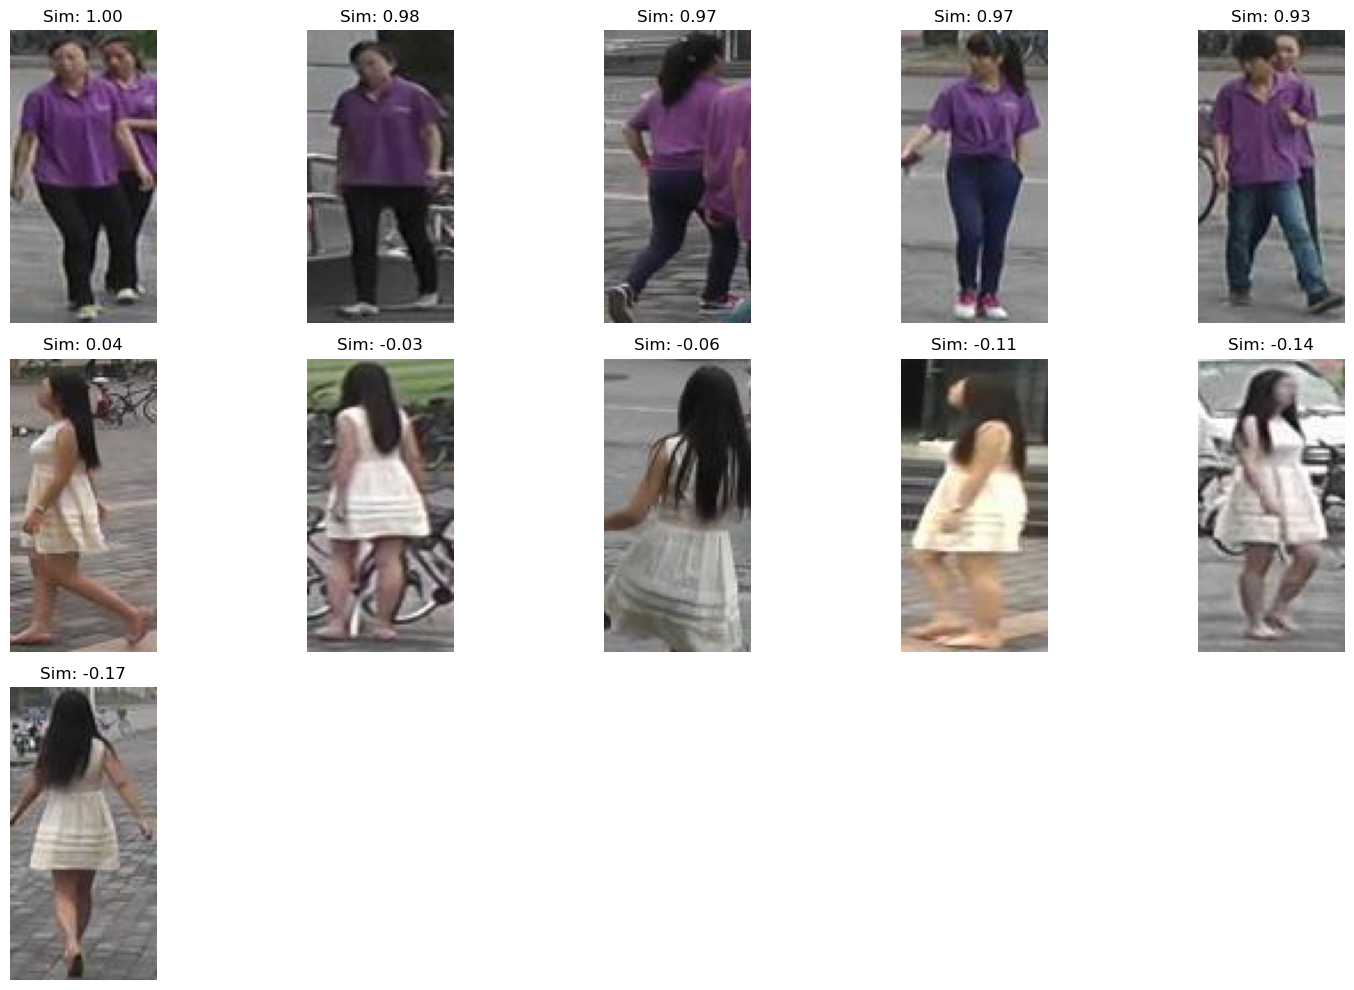

In [65]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Use the appropriate device based on availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = Person_ReID()
# Load the model with map_location to handle CPU-only environments
model.load_state_dict(torch.load('reid_model_3.2.pth', map_location=device))
model.eval()
model.to(device)

# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

def extract_features(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        features = model(image)
    return features

def find_top_matches(query_image_path, dataset_path, model, transform, top_k=11):
    query_features = extract_features(query_image_path, model, transform)
    
    similarities = []
    image_paths = []
    
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                # Extract features and compute similarity
                features = extract_features(image_path, model, transform)
                similarity = F.cosine_similarity(query_features, features).item()
                similarities.append(similarity)
    
    # Sort images by similarity
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    top_indices = sorted_indices[:top_k]
    
    # Visualize the top K matches
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(top_indices):
        plt.subplot(3, 5, i + 1)
        image = Image.open(image_paths[idx])
        plt.imshow(image)
        plt.title(f"Sim: {similarities[idx]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
query_image_path = '/Users/Shared/FYP/Capstone Project II - 3.2/Test Cases/Test Case 1/0 (3).jpg'
dataset_path = '/Users/Shared/FYP/Capstone Project II - 3.2/Test Cases/Test Case 1'
find_top_matches(query_image_path, dataset_path, model, transform)

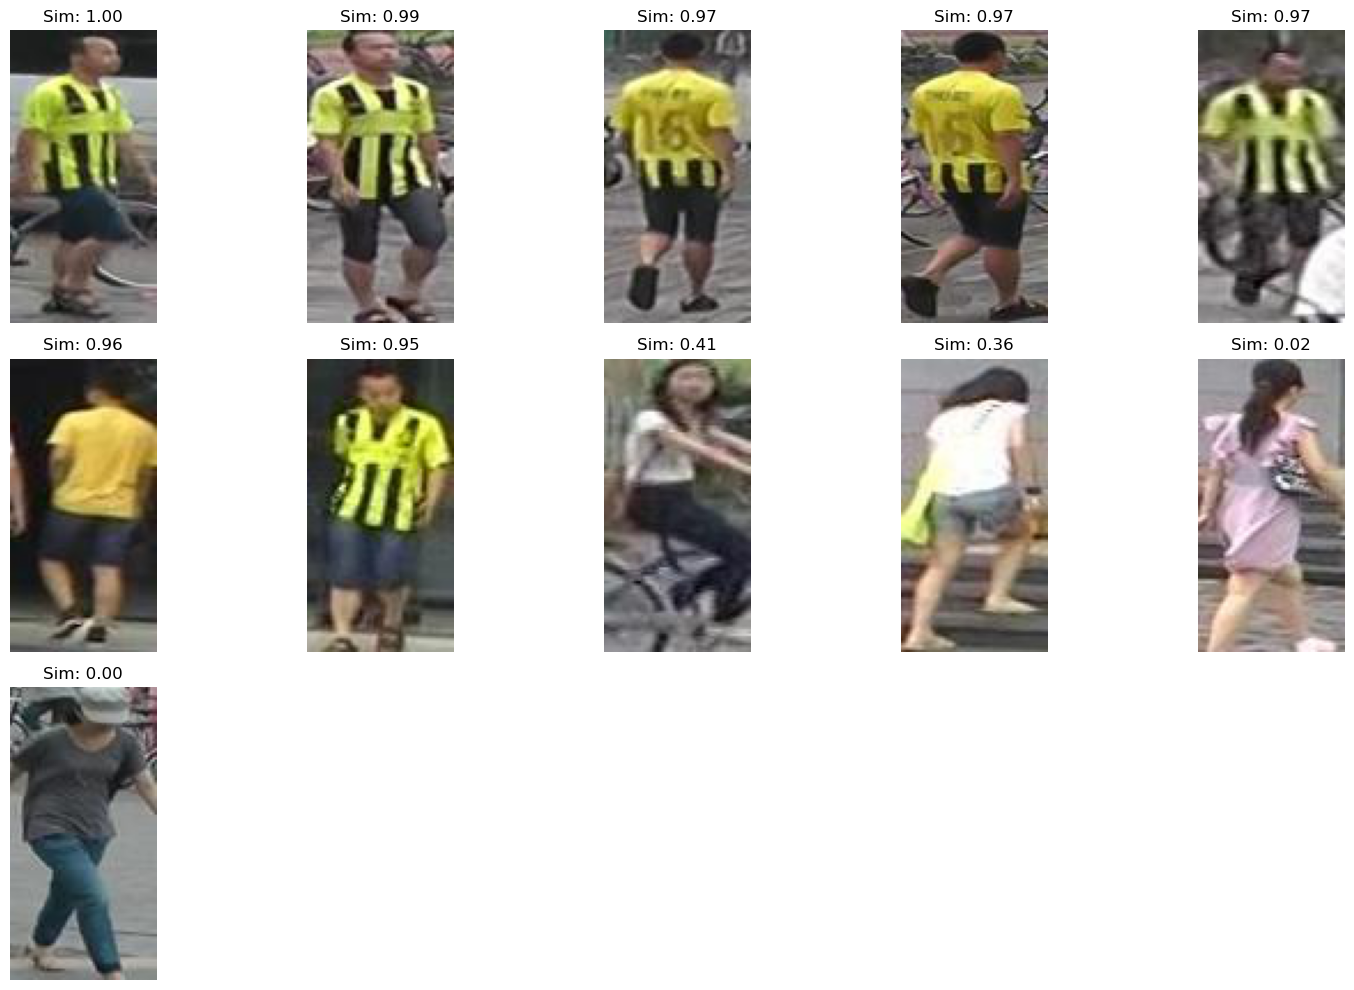

In [67]:
query_image_path = '/Users/Shared/FYP/Capstone Project II - 3.2/Test Cases/Test Case 2/0112_c2s1_018451_00.jpg'
dataset_path = '/Users/Shared/FYP/Capstone Project II - 3.2/Test Cases/Test Case 2'
find_top_matches(query_image_path, dataset_path, model, transform)

Confusion Matrix:

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = "mps"

def evaluate_model(model, data_loader, threshold=0.7):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            # Handle different data loader formats
            if len(batch) == 5:
                # Triplet dataset format: anchor, positive, negative, anchor_label, neg_label
                anchor_imgs, pos_imgs, neg_imgs, anchor_labels, neg_labels = batch
                anchor_imgs, pos_imgs, neg_imgs = anchor_imgs.to(device), pos_imgs.to(device), neg_imgs.to(device)
                
                # Forward pass
                anchor_emb = model(anchor_imgs)
                pos_emb = model(pos_imgs)
                neg_emb = model(neg_imgs)
                
                # Handle tuple outputs from model if needed
                if isinstance(anchor_emb, tuple):
                    anchor_emb = anchor_emb[0]
                if isinstance(pos_emb, tuple):
                    pos_emb = pos_emb[0]
                if isinstance(neg_emb, tuple):
                    neg_emb = neg_emb[0]
                
                # Compute similarities
                pos_sim = F.cosine_similarity(anchor_emb, pos_emb)
                neg_sim = F.cosine_similarity(anchor_emb, neg_emb)
                
                # Classify based on threshold
                pos_predictions = (pos_sim > threshold).cpu().numpy()
                neg_predictions = (neg_sim < threshold).cpu().numpy()
                
                # True labels (positive pairs should be 1, negative pairs should be 0)
                pos_labels = np.ones_like(pos_predictions)
                neg_labels = np.zeros_like(neg_predictions)
                
                # Collect all labels and predictions
                all_labels.extend(pos_labels)
                all_labels.extend(neg_labels)
                all_predictions.extend(pos_predictions)
                all_predictions.extend(neg_predictions)
            else:
                print(f"Unexpected batch format with {len(batch)} elements")
                break

    if len(all_labels) == 0:
        print("No data processed. Check data loader format.")
        return

    # Compute metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Run evaluation with the test_loader
if 'test_loader' in globals():
    print("Evaluating model on test dataset...")
    evaluate_model(model, test_loader)
else:
    print("test_loader not found. Please ensure it's defined before running evaluation.")

Evaluation function defined. Use with a properly configured test_loader.


t-SNE Visualization after Training:

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image

def compare_raw_vs_embeddings(dataset, model, device, title_prefix="Person ReID", max_samples=None):
    """
    Compare raw data visualization vs model embeddings
    
    Args:
        dataset: PreGeneratedTripletDataset instance
        model: Trained Person_ReID model
        device: Device to run inference ('cuda', 'mps', or 'cpu')
        title_prefix: Prefix for plot titles
        max_samples: Max number of samples to visualize (None for all)
    """
    model.eval()
    
    # Get a set of unique person images
    all_images = set()
    person_ids = {}
    
    # Determine samples to use
    if max_samples is None:
        sampled_indices = range(len(dataset))
    else:
        sampled_indices = torch.randperm(len(dataset))[:max_samples].tolist()
    
    # Extract unique images and their IDs
    for idx in sampled_indices:
        anchor, positive, negative, anchor_label, negative_label = dataset[idx]
        
        # Get paths for unique identification
        anchor_path = dataset.triplets[idx][0]
        positive_path = dataset.triplets[idx][1]
        negative_path = dataset.triplets[idx][2]
        
        # Add anchor and record person ID
        if anchor_path not in all_images:
            all_images.add(anchor_path)
            person_ids[anchor_path] = anchor_label
            
        # Add positive and record person ID
        if positive_path not in all_images:
            all_images.add(positive_path)
            person_ids[positive_path] = anchor_label
            
        # Add negative and record person ID
        if negative_path not in all_images:
            all_images.add(negative_path)
            person_ids[negative_path] = negative_label
    
    # Convert to lists
    image_paths = list(all_images)
    labels = [person_ids[path] for path in image_paths]
    
    print(f"Processing {len(image_paths)} unique images from {len(np.unique(labels))} different people")
    
    # Extract raw data and generate embeddings
    raw_data = []
    embeddings = []
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_imgs = []
            
            for path in batch_paths:
                img = Image.open(path).convert('RGB')
                if dataset.transform:
                    img = dataset.transform(img)
                
                # Store the raw image tensor (flattened) for t-SNE
                raw_img = img.clone().cpu().numpy().flatten()
                raw_data.append(raw_img)
                
                batch_imgs.append(img)
            
            # Process batch through model
            batch_tensor = torch.stack(batch_imgs).to(device)
            batch_embeddings = model(batch_tensor).cpu().numpy()
            embeddings.extend(batch_embeddings)
    
    raw_data = np.array(raw_data)
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    # t-SNE for raw data
    print("Computing t-SNE for raw image data...")
    tsne_raw = TSNE(n_components=2, random_state=42, perplexity=min(30, len(raw_data)-1))
    reduced_raw = tsne_raw.fit_transform(raw_data)
    
    # t-SNE for embeddings
    print("Computing t-SNE for model embeddings...")
    tsne_emb = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
    reduced_emb = tsne_emb.fit_transform(embeddings)
    
    # Create a custom color map with enough distinct colors
    unique_persons = np.unique(labels)
    n_colors = len(unique_persons)
    colors = plt.cm.hsv(np.linspace(0, 1, n_colors))
    
    # Shuffle the colors for better distinction while keeping consistency
    np.random.seed(42)
    np.random.shuffle(colors)
    
    # Create a color lookup dictionary
    color_map = {person_id: colors[i] for i, person_id in enumerate(unique_persons)}
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot raw data points
    for person_id in unique_persons:
        indices = np.where(labels == person_id)
        ax1.scatter(reduced_raw[indices, 0], reduced_raw[indices, 1], 
                   s=50, color=color_map[person_id], label=f"Person {person_id}")
    
    ax1.set_title(f"{title_prefix} - Raw Images", fontsize=18)
    ax1.set_xlabel("t-SNE Component 1", fontsize=14)
    ax1.set_ylabel("t-SNE Component 2", fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot model embeddings
    for person_id in unique_persons:
        indices = np.where(labels == person_id)
        ax2.scatter(reduced_emb[indices, 0], reduced_emb[indices, 1], 
                   s=50, color=color_map[person_id], label=f"Person {person_id}")
    
    ax2.set_title(f"{title_prefix} - Model Embeddings", fontsize=18)
    ax2.set_xlabel("t-SNE Component 1", fontsize=14)
    ax2.set_ylabel("t-SNE Component 2", fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add a single shared legend if there aren't too many classes
    if len(unique_persons) <= 20:
        handles, labels = ax2.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), 
                 ncol=min(len(unique_persons), 5), fontsize=12)
    
    # Calculate metrics for comparison
    # For embeddings
    same_id_similarities = []
    diff_id_similarities = []
    
    # Calculate the cosine similarity between each pair of embeddings
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            # The similarity is calculated using the cosine similarity
            sim = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
            if labels[i] == labels[j]:
                same_id_similarities.append(sim)  # Append similarity for same ID
            else:
                diff_id_similarities.append(sim)  # Append similarity for different IDs
    
    if same_id_similarities and diff_id_similarities:
        avg_same_id_sim = np.mean(same_id_similarities)
        avg_diff_id_sim = np.mean(diff_id_similarities)
        ratio = avg_same_id_sim / avg_diff_id_sim
        
        metrics_text = (
            f"Model Metrics:\n"
            f"Avg same ID sim: {avg_same_id_sim:.4f}\n"
            f"Avg diff ID sim: {avg_diff_id_sim:.4f}\n"
            f"Ratio: {ratio:.4f} (higher is better)"
        )
        
        # Add metrics to the plot
        plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=12, 
                  bbox=dict(facecolor='white', alpha=0.8))
        
        print(metrics_text)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for metrics text
    plt.show()
    
    return reduced_raw, reduced_emb, labels

# Example usage
model = Person_ReID().to(device)
#model.load_state_dict(torch.load('/Users/annsijaz/Documents/UMT/FYP/Capstone Project II - 2.0/best_triplet_model.pth'))
compare_raw_vs_embeddings(dataset=train_dataset, model=model, device=device, max_samples=None)

Processing 19769 unique images from 747 different people
Computing t-SNE for raw image data...


In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def extract_features(image_path, model, transform, device):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        features = model(image)
    return features

def evaluate_reid_performance(anchor_path, test_dir, model, threshold=0.5):
    """
    Evaluate Person ReID model performance using confusion matrix and metrics
    
    Args:
        anchor_path: Path to the anchor image
        test_dir: Directory containing test images
        model: Loaded Person ReID model
        threshold: Similarity threshold for determining matches
    """
    device = next(model.parameters()).device  # Get the device from the model
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Define transform - using the same as your extract_features function
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Extract anchor features
    anchor_features = extract_features(anchor_path, model, transform, device)
    
    # Lists to store results
    file_names = []
    similarities = []
    true_labels = []
    predicted_labels = []
    
    # Process all images in the test directory
    for file in os.listdir(test_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')) and not file.startswith('.'):
            # Skip the anchor image if it's in the test directory
            if file == os.path.basename(anchor_path):
                continue
                
            image_path = os.path.join(test_dir, file)
            
            # Extract features
            features = extract_features(image_path, model, transform, device)
            
            # Calculate similarity
            similarity = F.cosine_similarity(anchor_features, features).item()
            
            # Determine true label (1 = positive/same person, 0 = negative/different person)
            if file.startswith('1'):
                true_label = 1  # Same person as anchor
            else:
                true_label = 0  # Different person
                
            # Determine predicted label
            pred_label = 1 if similarity > threshold else 0
            
            # Store results
            file_names.append(file)
            similarities.append(similarity)
            true_labels.append(true_label)
            predicted_labels.append(pred_label)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Different Person', 'Same Person'], 
                yticklabels=['Different Person', 'Same Person'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Person ReID Confusion Matrix (Threshold={threshold:.2f})')
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"Model Performance Metrics (threshold={threshold:.2f}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print detailed results
    print("\nDetailed Results:")
    print(f"{'Image':<15} {'True':<10} {'Predicted':<10} {'Similarity':<10}")
    print("-" * 45)
    
    # Sort by similarity for better presentation
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    
    for i in sorted_indices:
        name = file_names[i]
        true = true_labels[i]
        pred = predicted_labels[i]
        sim = similarities[i]
        status = "✓" if true == pred else "✗"
        print(f"{name:<15} {true:<10} {pred:<10} {sim:.4f} {status}")
    
    # Plot similarity distribution
    plt.figure(figsize=(10, 6))
    
    # Get similarities for positive and negative samples
    pos_sims = [similarities[i] for i in range(len(similarities)) if true_labels[i] == 1]
    neg_sims = [similarities[i] for i in range(len(similarities)) if true_labels[i] == 0]
    
    plt.hist(pos_sims, alpha=0.7, label='Positive Samples (Same Person)', color='green', bins=5)
    plt.hist(neg_sims, alpha=0.7, label='Negative Samples (Different Person)', color='red', bins=5)
    
    plt.axvline(x=threshold, color='blue', linestyle='--', label=f'Threshold ({threshold})')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count')
    plt.title('Distribution of Similarities')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'similarities': similarities,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'file_names': file_names
    }

# Usage (using your existing extract_features function)
anchor_path = 'Test Case 3/anchor.jpg'
test_dir = '/Users/Shared/FYP/Capstone Project II - 3.2/Test Cases/Test Case 3'

# Make sure model is on the same device as the input tensors
model.to(device)
# Load weights with map_location to ensure they're on the correct device
model.load_state_dict(torch.load('best_triplet_model.pth', map_location=device))
model.eval()

results = evaluate_reid_performance(anchor_path, test_dir, model, threshold=0.5)

# Optionally try different thresholds to find optimal value
thresholds = [0.5, 0.6, 0.7]
for threshold in thresholds:
    print(f"\nEvaluating with threshold {threshold}")
    evaluate_reid_performance(anchor_path, test_dir, model, threshold=threshold)

NameError: name 'model' is not defined

Anchor image: anchor.jpg
Found 10 images (excluding anchor):
  1. 0 (0).jpg
  2. 0 (1).jpg
  3. 0 (2).jpg
  4. 0 (3).jpg
  5. 0 (4).jpg
  6. 1 (0).jpg
  7. 1 (1).jpg
  8. 1 (2).jpg
  9. 1 (3).jpg
  10. 1 (4).jpg

Positive images: 5
  1 (0).jpg
  1 (1).jpg
  1 (2).jpg
  1 (3).jpg
  1 (4).jpg
Negative images: 5
  0 (0).jpg
  0 (1).jpg
  0 (2).jpg
  0 (3).jpg
  0 (4).jpg

Computing embeddings...

Similarities with anchor:
nNegative images:
  1. 0 (0).jpg: 0.9480 > 0.5
  2. 0 (1).jpg: 0.9095 > 0.5
  3. 0 (2).jpg: 0.9276 > 0.5
  4. 0 (3).jpg: 0.9561 > 0.5
  5. 0 (4).jpg: 0.9686 > 0.5
\Positive images:
  1. 1 (0).jpg: 0.8815 > 0.5
  2. 1 (1).jpg: 0.9032 > 0.5
  3. 1 (2).jpg: 0.8932 > 0.5
  4. 1 (3).jpg: 0.8957 > 0.5
  5. 1 (4).jpg: 0.8663 > 0.5

Using threshold: 0.9

Predictions for positive images:
  1. True: 1, Pred: 1, Sim: 0.9480
  2. True: 1, Pred: 1, Sim: 0.9095
  3. True: 1, Pred: 1, Sim: 0.9276
  4. True: 1, Pred: 1, Sim: 0.9561
  5. True: 1, Pred: 1, Sim: 0.9686

Predictions for neg

/var/folders/3l/08v_97x95rb8qg41qcz_04wm0000gn/T/ipykernel_6398/4095705964.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/anns

<Figure size 800x600 with 0 Axes>

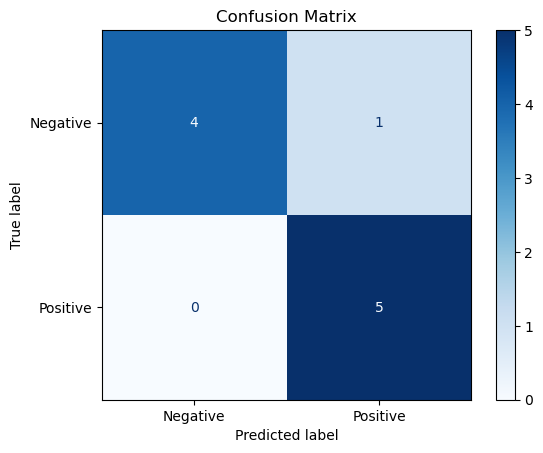

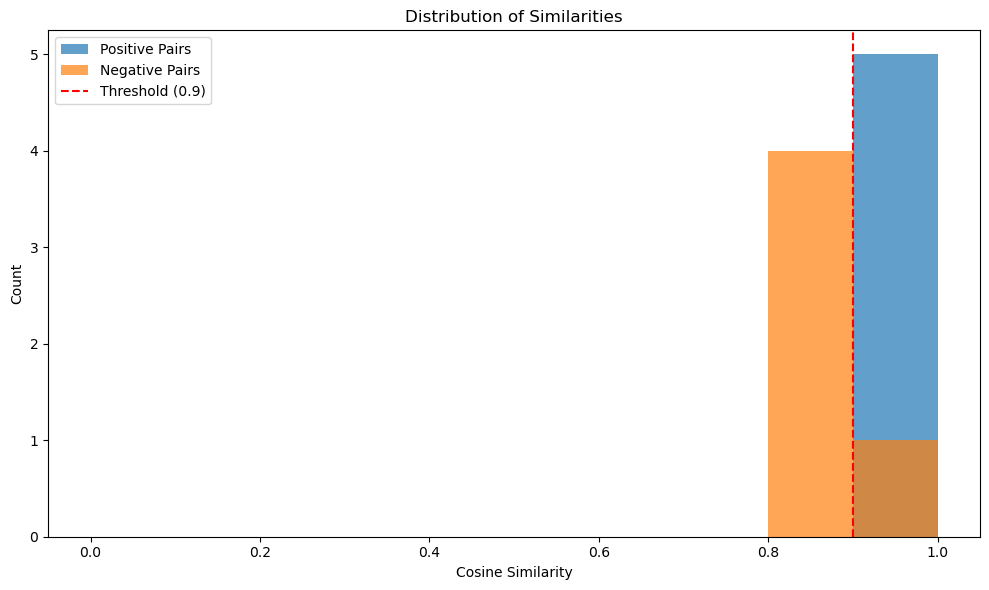

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load model
model = Person_ReID()  # Instantiate your model first
model.load_state_dict(torch.load("/Users/annsijaz/Documents/UMT/FYP/Capstone Project II/best_triplet_model.pth"))
model.to("mps")
model.eval()  # Set to evaluation mode

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
])

# Provide paths
anchor_path = "/Users/annsijaz/Documents/UMT/FYP/Capstone Project II/Test Case 1/anchor.jpg"
image_folder = "/Users/annsijaz/Documents/UMT/FYP/Capstone Project II/Test Case 1"

# Load anchor image
anchor_img = Image.open(anchor_path)
print(f"Anchor image: {os.path.basename(anchor_path)}")

# Load positive and negative images (excluding anchor)
valid_extensions = {".jpg", ".jpeg", ".png"}
image_files = sorted([
    img for img in os.listdir(image_folder)
    if img.lower().endswith(tuple(valid_extensions)) and img != os.path.basename(anchor_path)
])

print(f"Found {len(image_files)} images (excluding anchor):")
for i, img in enumerate(image_files):
    print(f"  {i+1}. {img}")

# First 5 are -ve and rest are +ve
pos_imgs = [Image.open(os.path.join(image_folder, img)) for img in image_files[5:]]
neg_imgs = [Image.open(os.path.join(image_folder, img)) for img in image_files[:5]]

print(f"\nPositive images: {len(pos_imgs)}")
for img in pos_imgs:
    print(f"  {os.path.basename(img.filename)}")

print(f"Negative images: {len(neg_imgs)}")
for img in neg_imgs:
    print(f"  {os.path.basename(img.filename)}")

# Convert images to embeddings
def get_embedding(model, image):
    image = transform(image).unsqueeze(0).to("mps")
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().squeeze().numpy()

# Get embeddings
print("\nComputing embeddings...")
anchor_emb = get_embedding(model, anchor_img)
pos_embs = [get_embedding(model, img) for img in pos_imgs]
neg_embs = [get_embedding(model, img) for img in neg_imgs]

# Compute cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Print all similarities
print("\nSimilarities with anchor:")
print("nNegative images:")
pos_similarities = []
for i, emb in enumerate(pos_embs):
    sim = cosine_similarity(anchor_emb, emb)
    pos_similarities.append(sim)
    print(f"  {i+1}. {image_files[i]}: {sim:.4f} {'> 0.5' if sim > 0.5 else '<= 0.5'}")

print("\Positive images:")
neg_similarities = []
for i, emb in enumerate(neg_embs):
    sim = cosine_similarity(anchor_emb, emb)
    neg_similarities.append(sim)
    print(f"  {i+1}. {image_files[i+5]}: {sim:.4f} {'> 0.5' if sim > 0.5 else '<= 0.5'}")

# Predict labels based on similarity threshold
threshold = 0.9
print(f"\nUsing threshold: {threshold}")

y_true = [1] * len(pos_imgs) + [0] * len(neg_imgs)  # 1 for positive, 0 for negative
y_pred = []

# Process positive images
print("\nPredictions for positive images:")
for i, sim in enumerate(pos_similarities):
    pred = 1 if sim > threshold else 0
    y_pred.append(pred)
    print(f"  {i+1}. True: 1, Pred: {pred}, Sim: {sim:.4f}")

# Process negative images
print("\nPredictions for negative images:")
for i, sim in enumerate(neg_similarities):
    pred = 1 if sim > threshold else 0  # THIS IS THE LOGICAL ERROR!
    y_pred.append(pred)
    print(f"  {i+1}. True: 0, Pred: {pred}, Sim: {sim:.4f}")

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Plot similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(pos_similarities, alpha=0.7, label='Positive Pairs', bins=10, range=(0, 1))
plt.hist(neg_similarities, alpha=0.7, label='Negative Pairs', bins=10, range=(0, 1))
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Distribution of Similarities')
plt.legend()
plt.tight_layout()
plt.show()